## Plotando bounding box do dataset sintetico

Usando o diretório base: 
Usando o diretório de treino: datasets_fanta/train
Usando o arquivo de anotações: datasets_fanta/train/metadata.jsonl
Arquivo JSONL 'datasets_fanta/train/metadata.jsonl' carregado com sucesso. Total de 294 entradas.
Informações encontradas para '0aedd0d98bef45c58963e01bb29a788d_0000.png':
{'file_name': '0aedd0d98bef45c58963e01bb29a788d_0000.png', 'objects': {'bbox': [[357.43083201236345, 26.25314869292771, 366.46770496749184, 344.71430996884976]], 'categories': [0]}}
Dimensões da imagem carregada: Largura=1024, Altura=512
Coordenadas brutas do JSON: [357.43083201236345, 26.25314869292771, 366.46770496749184, 344.71430996884976]


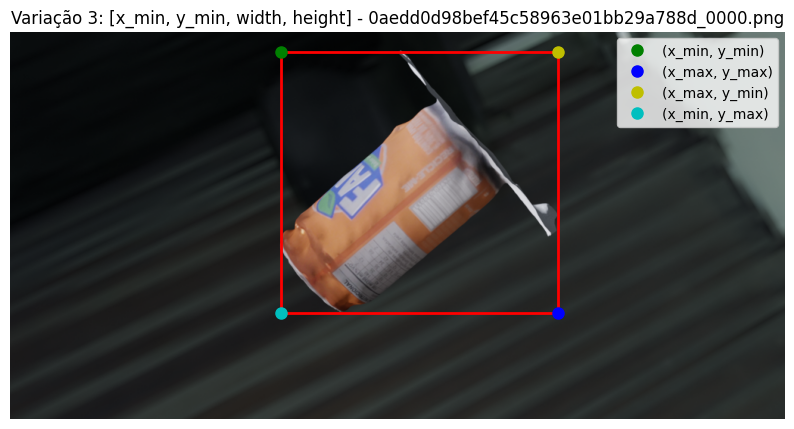

Plotagem da Variante 3 concluída.

Análise de dados inicial concluída.


In [1]:
import os
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import random

base_dir = "" 

train_dir = os.path.join(base_dir, "datasets_fanta", "train")
annotation_file = os.path.join(train_dir, "metadata.jsonl") # Assumindo que metadata.jsonl está dentro de train_dir

print(f"Usando o diretório base: {base_dir}")
print(f"Usando o diretório de treino: {train_dir}")
print(f"Usando o arquivo de anotações: {annotation_file}")

annotations = []
try:
    with open(annotation_file, 'r') as f:
        for line in f:
            annotations.append(json.loads(line.strip()))
    print(f"Arquivo JSONL '{annotation_file}' carregado com sucesso. Total de {len(annotations)} entradas.")
except FileNotFoundError:
    print(f"Erro: Arquivo '{annotation_file}' não encontrado. Por favor, verifique o caminho.")
    exit()
except json.JSONDecodeError as e:
    print(f"Erro: O arquivo '{annotation_file}' não é um JSONL válido. Detalhe: {e}")
    exit()
except Exception as e:
    print(f"Ocorreu um erro inesperado ao carregar o arquivo: {e}")
    exit()

# --- BLOCÃO DE TESTES PARA UMA ÚNICA IMAGEM DE EXEMPLO ---
example_file_name = "0aedd0d98bef45c58963e01bb29a788d_0000.png"
example_annotation = None
for ann in annotations:
    if ann["file_name"] == example_file_name:
        example_annotation = ann
        break

if example_annotation:
    print(f"Informações encontradas para '{example_file_name}':")
    print(example_annotation)

    img_path_with_bbox = os.path.join(train_dir, example_annotation["file_name"])

    try:
        original_img = Image.open(img_path_with_bbox).convert('RGB')
        img_width, img_height = original_img.size
        print(f"Dimensões da imagem carregada: Largura={img_width}, Altura={img_height}")

        for bbox_coords in example_annotation["objects"]["bbox"]:
            coord1, coord2, coord3, coord4 = bbox_coords
            print(f"Coordenadas brutas do JSON: [{coord1}, {coord2}, {coord3}, {coord4}]")

            # --- VARIANTE 3: Assumir [x_min, y_min, width, height] ---
            fig, ax = plt.subplots(1, figsize=(10, 10))
            ax.imshow(original_img)
            ax.set_title(f"Variação 3: [x_min, y_min, width, height] - {example_file_name}")
            ax.axis('off')

            x_min, y_min, width, height = coord1, coord2, coord3, coord4
            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.plot(x_min, y_min, 'go', markersize=8, label='(x_min, y_min)')
            ax.plot(x_min + width, y_min + height, 'bo', markersize=8, label='(x_max, y_max)')
            ax.plot(x_min + width, y_min, 'yo', markersize=8, label='(x_max, y_min)')
            ax.plot(x_min, y_min + height, 'co', markersize=8, label='(x_min, y_max)')
            ax.legend()
            plt.show()
            print(f"Plotagem da Variante 3 concluída.")

        
    except FileNotFoundError:
        print(f"Erro: Imagem '{img_path_with_bbox}' não encontrada. Verifique o caminho e o nome do arquivo.")
    except Exception as e:
        print(f"Erro ao plotar imagem com bounding box para '{example_file_name}': {e}")
else:
    print(f"Erro: A imagem de exemplo '{example_file_name}' não foi encontrada no arquivo JSONL carregado. "
          f"Verifique se o 'file_name' no JSONL corresponde exatamente ao nome do arquivo da imagem.")

print("\nAnálise de dados inicial concluída.")

## Plotando bounding box do dataset real

In [2]:
import os
import shutil
import json # Embora não usado diretamente para os .txt, pode ser útil se houvesse necessidade de re-parsing do YAML

# --- 1. Definição de Caminhos ---
# Por favor, ajuste 'roboflow_dataset_root' para o diretório raiz do seu dataset Roboflow.
# Este é o diretório que contém as pastas 'train', 'valid', 'test' (e possivelmente o data.yaml).
roboflow_dataset_root = 'base_dataset.yolov8' # Exemplo: './my_roboflow_dataset' ou o caminho absoluto

# Diretórios de entrada (do seu dataset Roboflow)
train_images_in = os.path.join(roboflow_dataset_root, 'train', 'images')
train_labels_in = os.path.join(roboflow_dataset_root, 'train', 'labels')
val_images_in = os.path.join(roboflow_dataset_root, 'valid', 'images')
val_labels_in = os.path.join(roboflow_dataset_root, 'valid', 'labels')
test_images_in = os.path.join(roboflow_dataset_root, 'test', 'images')
test_labels_in = os.path.join(roboflow_dataset_root, 'test', 'labels')

# Novo diretório de saída
new_dataset_root = './processed_single_object_dataset'
new_images_out = os.path.join(new_dataset_root, 'images')
new_labels_out = os.path.join(new_dataset_root, 'labels')

# Classe original a ser remapeada para 0
TARGET_CLASS_ID_ORIGINAL = 5
# Classe para todos os outros objetos (se existirem)
OTHER_CLASSES_ID_NEW = 1
# Nova classe para o objeto de interesse
TARGET_CLASS_ID_NEW = 0

# --- 2. Criação dos Novos Diretórios ---
os.makedirs(new_images_out, exist_ok=True)
os.makedirs(new_labels_out, exist_ok=True)
print(f"Novo diretório '{new_dataset_root}' criado com sucesso.")

# --- 3. Função para Processar um Split do Dataset ---
def process_dataset_split(images_input_dir, labels_input_dir, images_output_dir, labels_output_dir):
    print(f"\nProcessando imagens de: {images_input_dir}")
    image_files = [f for f in os.listdir(images_input_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    processed_count = 0
    for image_file in image_files:
        image_name_without_ext = os.path.splitext(image_file)[0]
        
        original_image_path = os.path.join(images_input_dir, image_file)
        original_label_path = os.path.join(labels_input_dir, image_name_without_ext + '.txt')
        
        new_label_lines = []
        
        # Tenta ler o arquivo de label original
        if os.path.exists(original_label_path):
            with open(original_label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        class_id_original = int(parts[0])
                        x_c, y_c, w, h = parts[1:] # Coordenadas já estão normalizadas
                        
                        if class_id_original == TARGET_CLASS_ID_ORIGINAL:
                            new_label_lines.append(f"{TARGET_CLASS_ID_NEW} {x_c} {y_c} {w} {h}")
                        else:
                            continue
        # else:
            # print(f"Aviso: Arquivo de label '{original_label_path}' não encontrado. Imagem será copiada sem novos labels (ou labels vazios se não houver objetos).")
            # Se o label não existe, new_label_lines permanece vazio, o que é um label vazio para YOLO.

        # Salva o novo arquivo de label no diretório de saída
        new_label_path = os.path.join(labels_output_dir, image_name_without_ext + '.txt')
        with open(new_label_path, 'w') as f:
            for line in new_label_lines:
                f.write(line + '\n')
        
        # Copia a imagem para o novo diretório de saída
        new_image_path = os.path.join(images_output_dir, image_file)
        shutil.copy2(original_image_path, new_image_path)
        processed_count += 1
    
    print(f"Total de {processed_count} imagens processadas de {images_input_dir}.")

# --- 4. Processar todos os splits do dataset ---
process_dataset_split(train_images_in, train_labels_in, new_images_out, new_labels_out)
process_dataset_split(val_images_in, val_labels_in, new_images_out, new_labels_out)
process_dataset_split(test_images_in, test_labels_in, new_images_out, new_labels_out)

print(f"\nProcessamento concluído. O novo dataset está em '{new_dataset_root}'.")
print(f"Todas as imagens e labels foram consolidadas em '{new_images_out}' e '{new_labels_out}'.")
print(f"Classe original {TARGET_CLASS_ID_ORIGINAL} foi remapeada para {TARGET_CLASS_ID_NEW}.")
print(f"Todas as outras classes foram remapeadas para {OTHER_CLASSES_ID_NEW}.")

Novo diretório './processed_single_object_dataset' criado com sucesso.

Processando imagens de: base_dataset.yolov8/train/images
Total de 408 imagens processadas de base_dataset.yolov8/train/images.

Processando imagens de: base_dataset.yolov8/valid/images
Total de 118 imagens processadas de base_dataset.yolov8/valid/images.

Processando imagens de: base_dataset.yolov8/test/images
Total de 61 imagens processadas de base_dataset.yolov8/test/images.

Processamento concluído. O novo dataset está em './processed_single_object_dataset'.
Todas as imagens e labels foram consolidadas em './processed_single_object_dataset/images' e './processed_single_object_dataset/labels'.
Classe original 5 foi remapeada para 0.
Todas as outras classes foram remapeadas para 1.



Procurando uma imagem com a nova Classe 0 para plotar...
Encontrada imagem para plotar: 2023-10-07-161305_jpg.rf.ed65da1a87b161477abb482488846e4a.jpg


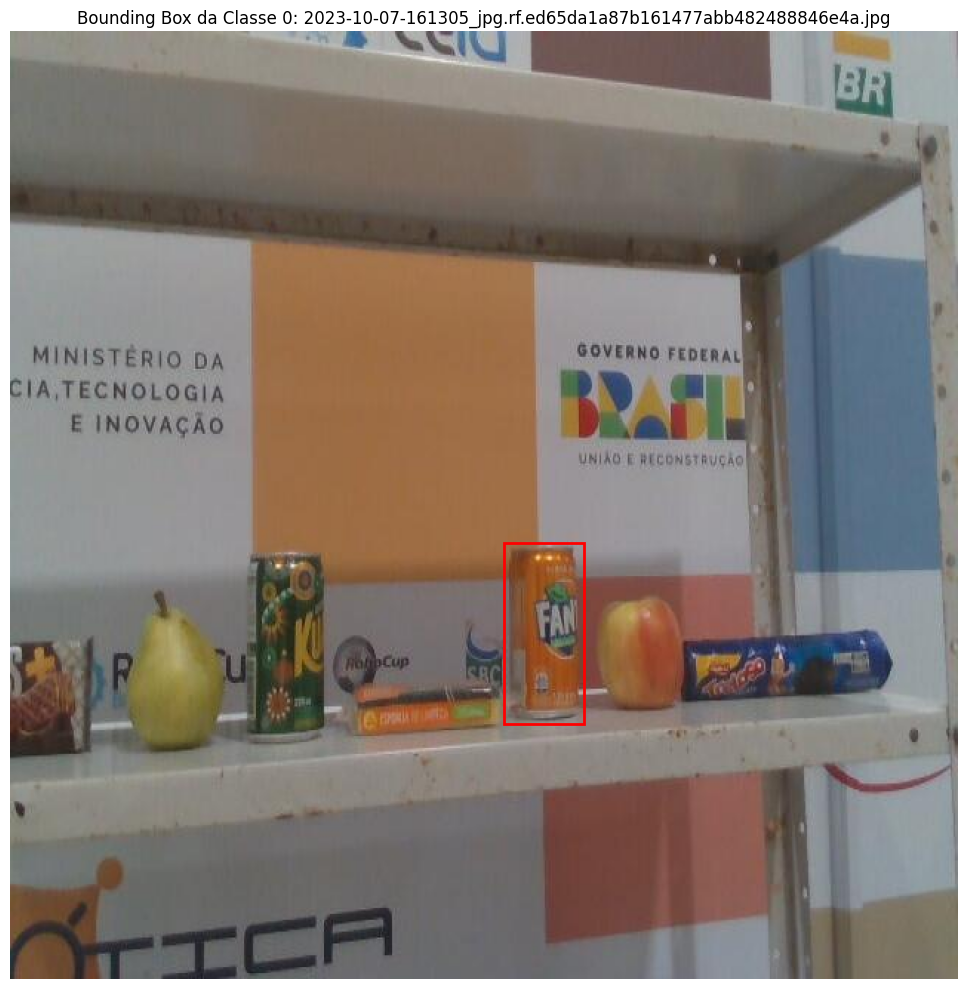

In [3]:
# --- Função de Plotagem ---
def plot_yolo_bbox(image_path, label_path):
    try:
        img = Image.open(image_path).convert('RGB')
        img_width, img_height = img.size

        fig, ax = plt.subplots(1, figsize=(10, 10))
        ax.imshow(img)
        ax.set_title(f"Bounding Box da Classe 0: {os.path.basename(image_path)}")
        ax.axis('off')

        if not os.path.exists(label_path):
            print(f"Erro: Arquivo de label '{label_path}' não encontrado.")
            plt.show()
            return

        with open(label_path, 'r') as f:
            labels = f.readlines()

        if not labels:
            print(f"Aviso: Arquivo de label '{label_path}' está vazio. Nenhuma bbox para plotar.")
            plt.show()
            return

        for label_line in labels:
            parts = label_line.strip().split()
            if len(parts) == 5:
                class_id = int(parts[0])
                x_center_norm, y_center_norm, width_norm, height_norm = map(float, parts[1:])

                if class_id == 0: # Plotar apenas a classe 0
                    # Converte de YOLO normalizado para pixels (x_min, y_min, width, height)
                    x_min_pixel = (x_center_norm - width_norm / 2) * img_width
                    y_min_pixel = (y_center_norm - height_norm / 2) * img_height
                    width_pixel = width_norm * img_width
                    height_pixel = height_norm * img_height

                    x_min_pixel = int(x_min_pixel)
                    y_min_pixel = int(y_min_pixel)
                    width_pixel = int(width_pixel)
                    height_pixel = int(height_pixel)

                    if width_pixel <= 0 or height_pixel <= 0:
                        print(f"Aviso: Bounding box inválida (largura ou altura <= 0). Não será plotada.")
                        continue
                    
                    x_max_pixel = x_min_pixel + width_pixel
                    y_max_pixel = y_min_pixel + height_pixel
                    
                    if x_max_pixel < 0 or y_max_pixel < 0 or x_min_pixel > img_width or y_min_pixel > img_height:
                        print(f"Aviso: Bounding box fora dos limites da imagem. Coords: [{x_min_pixel},{y_min_pixel},{x_max_pixel},{y_max_pixel}]")
                        continue

                    rect = patches.Rectangle(
                        (x_min_pixel, y_min_pixel),
                        width_pixel,
                        height_pixel,
                        linewidth=2,
                        edgecolor='red', # Cor vermelha para a classe 0
                        facecolor='none'
                    )
                    ax.add_patch(rect)
                # else:
                    # Se não é classe 0, não faz nada, pois você pediu para não plotar outros objetos.

        plt.tight_layout()
        plt.show()

    except FileNotFoundError:
        print(f"Erro: Imagem '{image_path}' ou arquivo de label não encontrado.")
    except Exception as e:
        print(f"Ocorreu um erro na plotagem: {e}")

# --- Encontrar e Plotar uma Imagem com a Nova Classe 0 ---
found_image_to_plot = None
print("\nProcurando uma imagem com a nova Classe 0 para plotar...")

# Itera sobre os novos labels gerados
new_label_files = [f for f in os.listdir(new_labels_out) if f.endswith('.txt')]

for label_file in new_label_files:
    label_path = os.path.join(new_labels_out, label_file)
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                class_id = int(parts[0])
                if class_id == TARGET_CLASS_ID_NEW: # Se encontrar a nova classe 0
                    image_name = os.path.splitext(label_file)[0] + '.jpg' # Assumindo .jpg para a imagem
                    image_path = os.path.join(new_images_out, image_name)
                    if os.path.exists(image_path):
                        found_image_to_plot = (image_path, label_path)
                        break # Encontrou, pode sair do loop de linhas
        if found_image_to_plot:
            break # Encontrou, pode sair do loop de arquivos

if found_image_to_plot:
    print(f"Encontrada imagem para plotar: {os.path.basename(found_image_to_plot[0])}")
    plot_yolo_bbox(found_image_to_plot[0], found_image_to_plot[1])
else:
    print("Nenhuma imagem com a nova Classe 0 encontrada no dataset processado.")
    print("Verifique se há objetos da classe original 5 no seu dataset Roboflow.")


## Gerando labels pro meu dataset da fanta

In [4]:
import os
import json
from PIL import Image

def generate_yolo_labels(image_dir, jsonl_file, labels_dir):
    """
    Gera arquivos de rótulos no formato YOLO (class_id x_center y_center width height, normalizado)
    a partir de um arquivo JSONL que contém bounding boxes no formato [x_min, y_min, width, height] em pixels.
    """
    os.makedirs(labels_dir, exist_ok=True) # Cria o diretório de labels se não existir

    # Carrega todas as anotações do arquivo JSONL
    annotations = []
    try:
        with open(jsonl_file, 'r') as f:
            for line in f:
                annotations.append(json.loads(line.strip()))
        print(f"Arquivo JSONL '{jsonl_file}' carregado com sucesso. Total de {len(annotations)} entradas.")
    except FileNotFoundError:
        print(f"ERRO: Arquivo JSONL '{jsonl_file}' não encontrado. Verifique o caminho.")
        return
    except json.JSONDecodeError as e:
        print(f"ERRO: O arquivo '{jsonl_file}' não é um JSONL válido. Detalhe: {e}")
        return
    except Exception as e:
        print(f"ERRO: Ocorreu um erro inesperado ao carregar o arquivo JSONL: {e}")
        return

    processed_images_count = 0
    # Percorre cada anotação para processar a imagem e gerar seu label
    for ann in annotations:
        file_name = ann["file_name"]
        image_id = os.path.splitext(file_name)[0]
        image_path = os.path.join(image_dir, file_name)
        label_file_path = os.path.join(labels_dir, image_id + '.txt')

        try:
            # Abre a imagem para obter suas dimensões (necessário para normalização)
            with Image.open(image_path) as img:
                img_width, img_height = img.size
        except FileNotFoundError:
            print(f"Aviso: Imagem '{image_path}' não encontrada. Pulando a geração de label para esta imagem.")
            continue
        except Exception as e:
            print(f"Aviso: Erro ao carregar a imagem '{image_path}' para obter dimensões: {e}. Pulando.")
            continue

        label_lines = []
        if "objects" in ann and "bbox" in ann["objects"] and "categories" in ann["objects"]:
            for i in range(len(ann["objects"]["bbox"])):
                # Lendo do JSON: [x_min_pixel, y_min_pixel, width_pixel, height_pixel]
                bbox_coords = ann["objects"]["bbox"][i]
                category_id = ann["objects"]["categories"][i]

                # Garante que temos 4 coordenadas para a bbox
                if len(bbox_coords) == 4:
                    x_min_pixel, y_min_pixel, width_pixel, height_pixel = bbox_coords

                    # Calcula o centro em pixels
                    x_center_pixel = x_min_pixel + width_pixel / 2
                    y_center_pixel = y_min_pixel + height_pixel / 2

                    # Normaliza todas as coordenadas para o formato YOLO (0 a 1)
                    x_center_normalized = x_center_pixel / img_width
                    y_center_normalized = y_center_pixel / img_height
                    width_normalized = width_pixel / img_width
                    height_normalized = height_pixel / img_height

                    # Adiciona a linha ao formato YOLO: class_id x_center y_center width height
                    label_lines.append(f"{category_id} {x_center_normalized:.6f} {y_center_normalized:.6f} {width_normalized:.6f} {height_normalized:.6f}")
                else:
                    print(f"Aviso: Bounding box com formato incorreto para {file_name}. Esperado 4 coordenadas, encontrado {len(bbox_coords)}.")

        # Escreve o arquivo .txt de label
        # Se label_lines estiver vazia (sem objetos ou erro no processamento), o arquivo .txt será vazio,
        # o que é o padrão YOLO para uma imagem sem objetos.
        with open(label_file_path, 'w') as f:
            for line in label_lines:
                f.write(line + '\n')
        processed_images_count += 1
    
    print(f"Geração de labels concluída. Processadas {processed_images_count} imagens.")

# --- Exemplo de Uso ---
# Ajuste 'base_dir' para o diretório que contém 'datasets_fanta'
# Ex: se seu script está em '/home/user/', e 'datasets_fanta' está em '/home/user/datasets_fanta/', use base_dir = '' ou './'
# Ou o caminho absoluto se preferir
base_dir = "" # Ajuste este caminho se necessário.
train_dir = os.path.join(base_dir, "datasets_fanta", "train") # Caminho para as imagens
annotation_file = os.path.join(train_dir, "metadata.jsonl") # Caminho para o seu arquivo JSONL
labels_output_dir = os.path.join("datasets_fanta", "labels") # Diretório onde os .txt serão salvos

print("--- INICIANDO GERAÇÃO DE LABELS ---")
generate_yolo_labels(train_dir, annotation_file, labels_output_dir)

--- INICIANDO GERAÇÃO DE LABELS ---
Arquivo JSONL 'datasets_fanta/train/metadata.jsonl' carregado com sucesso. Total de 294 entradas.
Geração de labels concluída. Processadas 294 imagens.


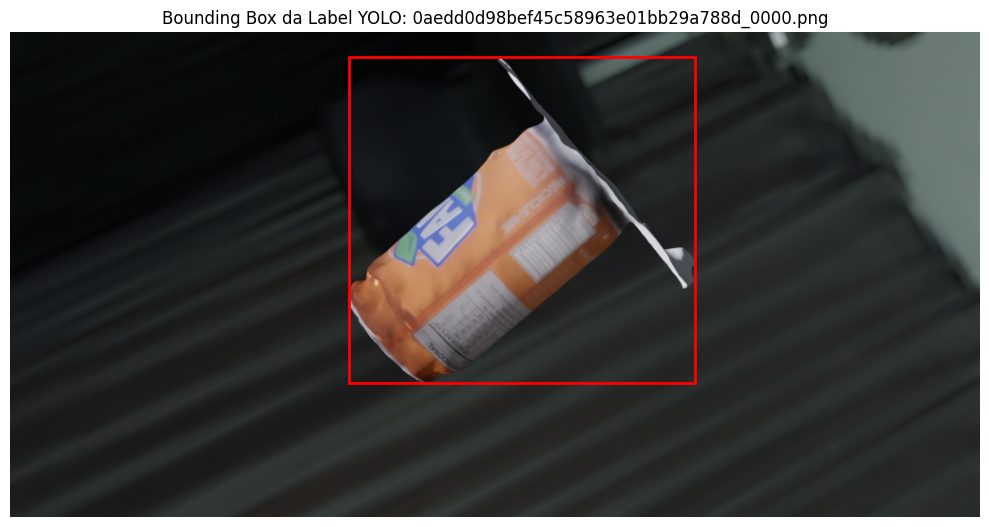

In [7]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def plot_bbox_from_yolo_label(image_path, label_path):
    try:
        img = Image.open(image_path).convert('RGB')
        img_width, img_height = img.size

        fig, ax = plt.subplots(1, figsize=(10, 10))
        ax.imshow(img)
        ax.set_title(f"Bounding Box da Label YOLO: {os.path.basename(image_path)}")
        ax.axis('off')

        if not os.path.exists(label_path):
            print(f"Erro: Arquivo de label '{label_path}' não encontrado.")
            plt.show()
            return

        with open(label_path, 'r') as f:
            labels = f.readlines()

        if not labels:
            print(f"Aviso: Arquivo de label '{label_path}' está vazio. Nenhuma bbox para plotar.")
            plt.show()
            return

        for label_line in labels:
            parts = label_line.strip().split()
            if len(parts) == 5:
                class_id = int(parts[0])
                x_center_norm, y_center_norm, width_norm, height_norm = map(float, parts[1:])

                # CONVERSÃO DE YOLO NORMALIZADO PARA PIXELS NO FORMATO (x_min, y_min, width, height)
                x_min_pixel = (x_center_norm - width_norm / 2) * img_width
                y_min_pixel = (y_center_norm - height_norm / 2) * img_height
                width_pixel = width_norm * img_width
                height_pixel = height_norm * img_height

                # Garante que as coordenadas sejam inteiras
                x_min_pixel = int(x_min_pixel)
                y_min_pixel = int(y_min_pixel)
                width_pixel = int(width_pixel)
                height_pixel = int(height_pixel)

                # --- Verificações de Validade para Evitar Problemas de Plotagem ---
                if width_pixel <= 0 or height_pixel <= 0:
                    print(f"Aviso: Bounding box calculada é inválida (largura ou altura <= 0). Não será plotada.")
                    continue
                
                # Calcula x_max e y_max para verificação de limites
                x_max_pixel = x_min_pixel + width_pixel
                y_max_pixel = y_min_pixel + height_pixel
                
                if x_max_pixel < 0 or y_max_pixel < 0 or x_min_pixel > img_width or y_min_pixel > img_height:
                    print(f"Aviso: Bounding box fora dos limites da imagem. Coords: [{x_min_pixel},{y_min_pixel},{x_max_pixel},{y_max_pixel}]")
                    continue

                # Desenha o retângulo usando matplotlib.patches.Rectangle
                rect = patches.Rectangle(
                    (x_min_pixel, y_min_pixel), # Canto superior esquerdo (x, y)
                    width_pixel,                 # Largura do retângulo
                    height_pixel,                # Altura do retângulo
                    linewidth=2,
                    edgecolor='red',             # Cor padrão (vermelho)
                    facecolor='none'
                )
                ax.add_patch(rect)

        plt.tight_layout()
        plt.show()

    except FileNotFoundError:
        print(f"Erro: Imagem '{image_path}' ou arquivo de label não encontrado.")
    except Exception as e:
        print(f"Ocorreu um erro na plotagem: {e}")

# --- Exemplo de Uso ---
# Adapte estes caminhos para o seu setup
base_dir = "" # Se 'datasets_fanta' está na mesma pasta do script, use ""
train_dir = os.path.join(base_dir, "datasets_fanta", "train") # Caminho para as imagens
labels_dir = os.path.join(train_dir, "labels") # Caminho para onde os .txt foram salvos

# Nome da imagem de exemplo (que você sabe que tem um label gerado)
sample_image_file = "0aedd0d98bef45c58963e01bb29a788d_0000.png" 

sample_image_path = os.path.join(train_dir, sample_image_file)
sample_label_path = os.path.join("datasets_fanta/labels", os.path.splitext(sample_image_file)[0] + ".txt")

# Chamar a função de plotagem
plot_bbox_from_yolo_label(sample_image_path, sample_label_path)

## Analise exploratoria dados reais

In [11]:
import os

# --- Definição de Caminhos ---
# Certifique-se de que este caminho aponta para o diretório raiz do seu dataset processado
# que foi criado na etapa anterior.
processed_dataset_root = 'datasets_fanta/train'
processed_labels_dir = os.path.join(processed_dataset_root, 'labels')

# --- Análise ---
images_with_target_object = 0
images_without_target_object = 0
total_images_checked = 0

print(f"Iniciando a análise dos labels em: {processed_labels_dir}")

# Verifica se o diretório de labels processados existe
if not os.path.exists(processed_labels_dir):
    print(f"Erro: O diretório de labels '{processed_labels_dir}' não foi encontrado.")
    print("Por favor, certifique-se de que a etapa de processamento do dataset foi executada.")
else:
    label_files = [f for f in os.listdir(processed_labels_dir) if f.endswith('.txt')]
    
    if not label_files:
        print(f"Aviso: Nenhum arquivo .txt encontrado em '{processed_labels_dir}'. O dataset pode estar vazio ou os labels não foram gerados.")
    else:
        for label_file in label_files:
            label_path = os.path.join(processed_labels_dir, label_file)
            total_images_checked += 1
            
            has_target_object_in_image = False
            
            try:
                with open(label_path, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) > 0:
                            class_id = int(parts[0])
                            if class_id == 0: # Nossa classe de interesse remapeada
                                has_target_object_in_image = True
                                break # Encontrou, pode parar de ler este arquivo
                
                if has_target_object_in_image:
                    images_with_target_object += 1
                else:
                    images_without_target_object += 1
            
            except Exception as e:
                print(f"Erro ao ler o arquivo de label '{label_file}': {e}. Pulando.")

print("\n--- Resultados da Análise ---")
print(f"Total de imagens com labels verificados: {total_images_checked}")
print(f"Imagens que contêm a classe 0 (nosso objeto): {images_with_target_object}")
print(f"Imagens que NÃO contêm a classe 0 (outros objetos ou vazias): {images_without_target_object}")

if total_images_checked > 0:
    percentage_with_object = (images_with_target_object / total_images_checked) * 100
    percentage_without_object = (images_without_target_object / total_images_checked) * 100
    print(f"Porcentagem de imagens com a classe 0: {percentage_with_object:.2f}%")
    print(f"Porcentagem de imagens SEM a classe 0: {percentage_without_object:.2f}%")
else:
    print("Nenhuma imagem processada para análise.")

Iniciando a análise dos labels em: datasets_fanta/train/labels

--- Resultados da Análise ---
Total de imagens com labels verificados: 661
Imagens que contêm a classe 0 (nosso objeto): 294
Imagens que NÃO contêm a classe 0 (outros objetos ou vazias): 367
Porcentagem de imagens com a classe 0: 44.48%
Porcentagem de imagens SEM a classe 0: 55.52%


In [10]:
import os
import shutil
import random

# --- Definição de Caminhos ---
# Diretório raiz do dataset processado (saída da etapa anterior).
# Certifique-se de que este caminho está correto.
processed_dataset_root = 'processed_single_object_dataset'
processed_images_dir = os.path.join(processed_dataset_root, 'images')
processed_labels_dir = os.path.join(processed_dataset_root, 'labels')

# Diretórios de destino (conforme solicitado).
# O diretório 'datasets_fanta' será criado ou usado como base.
output_base_dir = './datasets_fanta' 

test_images_out = os.path.join(output_base_dir, 'test', 'images')
test_labels_out = os.path.join(output_base_dir, 'test', 'labels')

train_images_out = os.path.join(output_base_dir, 'train', 'images')
train_labels_out = os.path.join(output_base_dir, 'train', 'labels')

# Nova classe do objeto de interesse (remapeada para 0)
TARGET_CLASS_ID_NEW = 0 

# --- Criação dos Diretórios de Destino ---
os.makedirs(test_images_out, exist_ok=True)
os.makedirs(test_labels_out, exist_ok=True)
os.makedirs(train_images_out, exist_ok=True)
os.makedirs(train_labels_out, exist_ok=True)
print(f"Diretórios de destino criados em '{output_base_dir}'.")

# --- Categorizar Imagens por Presença do Objeto ---
list_with_object_filenames = []
list_without_object_filenames = []

print("\nCategorizando imagens do dataset processado...")
if not os.path.exists(processed_labels_dir) or not os.path.exists(processed_images_dir):
    print(f"Erro: O diretório do dataset processado '{processed_dataset_root}' não foi encontrado.")
    print("Certifique-se de que a etapa de processamento do dataset foi executada corretamente.")
else:
    label_files = [f for f in os.listdir(processed_labels_dir) if f.endswith('.txt')]
    
    if not label_files:
        print(f"Aviso: Nenhum arquivo .txt encontrado em '{processed_labels_dir}'. Nenhuma separação a ser feita.")
    else:
        for label_file in label_files:
            label_path = os.path.join(processed_labels_dir, label_file)
            image_name_without_ext = os.path.splitext(label_file)[0]
            
            has_target_object_in_image = False
            try:
                with open(label_path, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) > 0:
                            class_id = int(parts[0])
                            if class_id == TARGET_CLASS_ID_NEW:
                                has_target_object_in_image = True
                                break
                
                if has_target_object_in_image:
                    list_with_object_filenames.append(image_name_without_ext)
                else:
                    list_without_object_filenames.append(image_name_without_ext)
            except Exception as e:
                print(f"Aviso: Erro ao ler o arquivo de label '{label_file}': {e}. Pulando.")

print(f"Encontradas {len(list_with_object_filenames)} imagens COM o objeto.")
print(f"Encontradas {len(list_without_object_filenames)} imagens SEM o objeto.")

# --- Distribuição para os Diretórios 'test' e 'train' ---

# Todas as 110 imagens que têm o objeto vão para 'test'
test_with_object_filenames = list_with_object_filenames[:] # Copia a lista

# 110 imagens que NÃO têm o objeto vão para 'test' (aleatoriamente)
num_without_object_for_test = 110
random.shuffle(list_without_object_filenames) # Embaralha para pegar aleatoriamente
test_without_object_filenames = list_without_object_filenames[:num_without_object_for_test]
train_without_object_filenames = list_without_object_filenames[num_without_object_for_test:] # O restante vai para 'train'

print(f"\nDistribuindo imagens:")
print(f"- {len(test_with_object_filenames)} imagens COM objeto serão movidas para {output_base_dir}/test")
print(f"- {len(test_without_object_filenames)} imagens SEM objeto serão movidas para {output_base_dir}/test")
print(f"- {len(train_without_object_filenames)} imagens SEM objeto serão movidas para {output_base_dir}/train")

# --- Função Auxiliar para Mover Arquivos ---
def move_files(filenames_list, source_images_dir, source_labels_dir, dest_images_dir, dest_labels_dir):
    moved_count = 0
    for file_id in filenames_list:
        # Tenta encontrar a imagem com as extensões mais comuns
        image_src_path = None
        for ext in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']:
            temp_path = os.path.join(source_images_dir, file_id + ext)
            if os.path.exists(temp_path):
                image_src_path = temp_path
                break
        
        label_src_path = os.path.join(source_labels_dir, file_id + '.txt')

        if image_src_path and os.path.exists(label_src_path):
            try:
                shutil.move(image_src_path, os.path.join(dest_images_dir, os.path.basename(image_src_path)))
                shutil.move(label_src_path, os.path.join(dest_labels_dir, os.path.basename(label_src_path)))
                moved_count += 1
            except Exception as e:
                print(f"Erro ao mover '{file_id}': {e}")
        else:
            print(f"Aviso: Arquivos (imagem ou label) para '{file_id}' não encontrados em origem. Não movido.")
    return moved_count

# --- Mover para 'test' ---
moved_to_test_with_object = move_files(test_with_object_filenames, processed_images_dir, processed_labels_dir, test_images_out, test_labels_out)
moved_to_test_without_object = move_files(test_without_object_filenames, processed_images_dir, processed_labels_dir, test_images_out, test_labels_out)

# --- Mover para 'train' ---
moved_to_train_without_object = move_files(train_without_object_filenames, processed_images_dir, processed_labels_dir, train_images_out, train_labels_out)

print("\n--- Separação Finalizada ---")
print(f"Movido {moved_to_test_with_object} imagens COM objeto para '{output_base_dir}/test'.")
print(f"Movido {moved_to_test_without_object} imagens SEM objeto para '{output_base_dir}/test'.")
print(f"Movido {moved_to_train_without_object} imagens SEM objeto para '{output_base_dir}/train'.")
print(f"Verifique os diretórios '{output_base_dir}/test' e '{output_base_dir}/train'.")

Diretórios de destino criados em './datasets_fanta'.

Categorizando imagens do dataset processado...
Encontradas 110 imagens COM o objeto.
Encontradas 477 imagens SEM o objeto.

Distribuindo imagens:
- 110 imagens COM objeto serão movidas para ./datasets_fanta/test
- 110 imagens SEM objeto serão movidas para ./datasets_fanta/test
- 367 imagens SEM objeto serão movidas para ./datasets_fanta/train

--- Separação Finalizada ---
Movido 110 imagens COM objeto para './datasets_fanta/test'.
Movido 110 imagens SEM objeto para './datasets_fanta/test'.
Movido 367 imagens SEM objeto para './datasets_fanta/train'.
Verifique os diretórios './datasets_fanta/test' e './datasets_fanta/train'.


In [15]:
import os
import shutil
import random

# --- Definição de Caminhos ---
# Diretório onde o conjunto de teste atual está
source_test_base_dir = './datasets_fanta/test'
source_test_images_dir = os.path.join(source_test_base_dir, 'images')
source_test_labels_dir = os.path.join(source_test_base_dir, 'labels')

# Novo diretório para validação
validation_base_dir = './datasets_fanta/validation'
validation_images_out = os.path.join(validation_base_dir, 'images')
validation_labels_out = os.path.join(validation_base_dir, 'labels')

# O diretório 'test' original será reabastecido com a outra metade
# Seus caminhos permanecem os mesmos, mas os arquivos serão movidos para lá
destination_test_images_out = os.path.join(source_test_base_dir, 'images')
destination_test_labels_out = os.path.join(source_test_base_dir, 'labels')


# --- Criação dos Novos Diretórios de Validação ---
os.makedirs(validation_images_out, exist_ok=True)
os.makedirs(validation_labels_out, exist_ok=True)
print(f"Diretórios de validação criados em '{validation_base_dir}'.")

# --- Coleta de Arquivos do Teste Atual ---
test_files_to_split = [] # Lista de nomes de arquivos (sem extensão)
if not os.path.exists(source_test_images_dir) or not os.path.exists(source_test_labels_dir):
    print(f"Erro: O diretório de teste original '{source_test_base_dir}' não foi encontrado.")
    print("Por favor, certifique-se de que a etapa anterior de separação foi executada.")
else:
    image_files = [f for f in os.listdir(source_test_images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    for img_file in image_files:
        test_files_to_split.append(os.path.splitext(img_file)[0])

    if not test_files_to_split:
        print(f"Aviso: Nenhuma imagem encontrada em '{source_test_images_dir}'. Nenhuma divisão a ser feita.")
    else:
        print(f"Total de {len(test_files_to_split)} imagens encontradas no diretório de teste original para divisão.")

        # Embaralha a lista para garantir uma divisão aleatória
        random.shuffle(test_files_to_split)

        # Calcula o ponto de divisão (metade)
        split_point = len(test_files_to_split) // 2

        # Divide os arquivos
        files_for_validation = test_files_to_split[:split_point]
        files_for_new_test = test_files_to_split[split_point:]

        print(f"Serão movidas {len(files_for_validation)} imagens para validação.")
        print(f"Serão mantidas {len(files_for_new_test)} imagens no novo teste.")

        # --- Função Auxiliar para Mover Arquivos ---
        def move_files_for_split(filenames_list, source_images_dir, source_labels_dir, dest_images_dir, dest_labels_dir):
            moved_count = 0
            for file_id in filenames_list:
                # Tenta encontrar a imagem com as extensões mais comuns
                image_src_path = None
                for ext in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']:
                    temp_path = os.path.join(source_images_dir, file_id + ext)
                    if os.path.exists(temp_path):
                        image_src_path = temp_path
                        break
                
                label_src_path = os.path.join(source_labels_dir, file_id + '.txt')

                if image_src_path and os.path.exists(label_src_path):
                    try:
                        shutil.move(image_src_path, os.path.join(dest_images_dir, os.path.basename(image_src_path)))
                        shutil.move(label_src_path, os.path.join(dest_labels_dir, os.path.basename(label_src_path)))
                        moved_count += 1
                    except Exception as e:
                        print(f"Erro ao mover '{file_id}': {e}")
                # else:
                    # print(f"Aviso: Arquivos (imagem ou label) para '{file_id}' não encontrados na origem durante a divisão. Não movido.")
            return moved_count

        # --- Mover para o diretório de Validação ---
        print("\nMovendo arquivos para o diretório de validação...")
        moved_to_validation = move_files_for_split(
            files_for_validation,
            source_test_images_dir,
            source_test_labels_dir,
            validation_images_out,
            validation_labels_out
        )
        print(f"Movido {moved_to_validation} arquivos para '{validation_base_dir}'.")
        
        # Os arquivos restantes em source_test_base_dir já são o novo conjunto de teste
        # Não precisamos movê-los novamente, eles simplesmente permanecem lá.
        print(f"Os {len(files_for_new_test)} arquivos restantes em '{source_test_base_dir}' agora compõem o novo conjunto de teste.")


        print("\n--- Divisão de Teste/Validação Concluída ---")
        print(f"Verifique os diretórios '{validation_base_dir}' (validação) e '{source_test_base_dir}' (novo teste).")

Diretórios de validação criados em './datasets_fanta/validation'.
Total de 220 imagens encontradas no diretório de teste original para divisão.
Serão movidas 110 imagens para validação.
Serão mantidas 110 imagens no novo teste.

Movendo arquivos para o diretório de validação...
Movido 110 arquivos para './datasets_fanta/validation'.
Os 110 arquivos restantes em './datasets_fanta/test' agora compõem o novo conjunto de teste.

--- Divisão de Teste/Validação Concluída ---
Verifique os diretórios './datasets_fanta/validation' (validação) e './datasets_fanta/test' (novo teste).


In [1]:
import os
import shutil

# --- Definição de Caminhos ---
base_dataset_root = './datasets_fanta' # Diretório raiz do seu dataset

# Splits do dataset a serem processados
dataset_splits = ['train', 'test', 'validation'] 

print(f"Iniciando a limpeza do dataset em '{base_dataset_root}'...")

total_removed_images = 0
total_removed_labels = 0

for split in dataset_splits:
    images_dir = os.path.join(base_dataset_root, split, 'images')
    labels_dir = os.path.join(base_dataset_root, split, 'labels')

    print(f"\nProcessando split: {split}")
    print(f"Verificando imagens em: {images_dir}")
    print(f"Verificando labels em: {labels_dir}")

    if not os.path.exists(images_dir):
        print(f"Aviso: Diretório de imagens '{images_dir}' não encontrado. Pulando este split.")
        continue
    if not os.path.exists(labels_dir):
        print(f"Aviso: Diretório de labels '{labels_dir}' não encontrado. Pulando este split.")
        continue

    label_files = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]
    
    current_split_removed_images = 0
    current_split_removed_labels = 0

    for label_file in label_files:
        label_path = os.path.join(labels_dir, label_file)
        image_name_without_ext = os.path.splitext(label_file)[0]
        
        # Tenta encontrar a imagem correspondente (verifica várias extensões comuns)
        corresponding_image_path = None
        for ext in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']:
            temp_image_path = os.path.join(images_dir, image_name_without_ext + ext)
            if os.path.exists(temp_image_path):
                corresponding_image_path = temp_image_path
                break

        # 1. Verifica se o arquivo .txt está vazio
        is_label_file_empty = False
        try:
            with open(label_path, 'r') as f:
                content = f.read().strip()
                if not content: # Se o conteúdo for vazio ou apenas whitespace
                    is_label_file_empty = True
        except Exception as e:
            print(f"Erro ao ler o arquivo de label '{label_path}': {e}. Pulando este arquivo.")
            continue

        if is_label_file_empty:
            print(f"Removendo label vazio: {label_file}")
            os.remove(label_path)
            current_split_removed_labels += 1
            
            if corresponding_image_path and os.path.exists(corresponding_image_path):
                print(f"Removendo imagem correspondente (label vazio): {os.path.basename(corresponding_image_path)}")
                os.remove(corresponding_image_path)
                current_split_removed_images += 1
            # else:
                # print(f"Aviso: Imagem correspondente a {label_file} (label vazio) não encontrada.")
    
    print(f"Total de {current_split_removed_labels} labels vazios removidos em '{split}'.")
    print(f"Total de {current_split_removed_images} imagens correspondentes removidas em '{split}'.")
    total_removed_images += current_split_removed_images
    total_removed_labels += current_split_removed_labels

print(f"\nLimpeza completa.")
print(f"Total de imagens removidas em todo o dataset: {total_removed_images}")
print(f"Total de arquivos de labels removidos em todo o dataset: {total_removed_labels}")

Iniciando a limpeza do dataset em './datasets_fanta'...

Processando split: train
Verificando imagens em: ./datasets_fanta/train/images
Verificando labels em: ./datasets_fanta/train/labels
Removendo label vazio: 2023-10-08-074716_jpg.rf.373e85ccad595858a48b4a815843f7fd.txt
Removendo imagem correspondente (label vazio): 2023-10-08-074716_jpg.rf.373e85ccad595858a48b4a815843f7fd.jpg
Removendo label vazio: 2023-10-08-075028_jpg.rf.8ec71d4b89de5f347ca2a564d92e653c.txt
Removendo imagem correspondente (label vazio): 2023-10-08-075028_jpg.rf.8ec71d4b89de5f347ca2a564d92e653c.jpg
Removendo label vazio: 20231007_164222_jpg.rf.17b40d090fae0e40ea1b22e34f65e60a.txt
Removendo imagem correspondente (label vazio): 20231007_164222_jpg.rf.17b40d090fae0e40ea1b22e34f65e60a.jpg
Removendo label vazio: 2023-10-07-163408_jpg.rf.5c7c96b4f5913ad0f69a512a43c683d9.txt
Removendo imagem correspondente (label vazio): 2023-10-07-163408_jpg.rf.5c7c96b4f5913ad0f69a512a43c683d9.jpg
Removendo label vazio: 2023-10-08-08120

In [2]:
import os

# --- Definição de Caminhos ---
base_dataset_root = './datasets_fanta' # Diretório raiz do seu dataset
dataset_splits = ['train', 'test', 'validation'] 

print(f"Contando imagens em cada split do dataset em '{base_dataset_root}'...")

total_images_in_dataset = 0

for split in dataset_splits:
    images_dir = os.path.join(base_dataset_root, split, 'images')

    print(f"\n--- Split: {split} ---")
    
    if not os.path.exists(images_dir):
        print(f"Diretório de imagens '{images_dir}' não encontrado.")
        num_images_in_split = 0
    else:
        # Contar arquivos de imagem (considerando extensões comuns)
        num_images_in_split = 0
        for root, _, files in os.walk(images_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    num_images_in_split += 1
        
        print(f"Número de imagens: {num_images_in_split}")
        total_images_in_dataset += num_images_in_split

print(f"\n--- Resumo Total ---")
print(f"Total de imagens em todo o dataset: {total_images_in_dataset}")

Contando imagens em cada split do dataset em './datasets_fanta'...

--- Split: train ---
Número de imagens: 588

--- Split: test ---
Número de imagens: 61

--- Split: validation ---
Número de imagens: 49

--- Resumo Total ---
Total de imagens em todo o dataset: 698


## Treino do modelo

In [ ]:
#!pip install ultralytics
#!pip install torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.4 MB/s eta 0:00:00 0:00:01


In [18]:
import torch
if torch.backends.mps.is_available():
    print("MPS está disponível. Usando GPU do macOS.")
else:
    print("MPS não está disponível. O treinamento pode ser mais lento.")

MPS está disponível. Usando GPU do macOS.


In [1]:
from ultralytics import YOLO

model = YOLO("yolo11n.pt")

model.train(data="config_yolo.yaml", epochs=200, device="mps",imgsz=160,
            plots=True,freeze=10,batch=0.90,save_period=50,project='models',name=f'yolo8_200_epocas')


Ultralytics 8.3.169 🚀 Python-3.10.13 torch-2.7.1 MPS (Apple M1)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=0.9, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=config_yolo.yaml, degrees=0.0, deterministic=True, device=mps, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=160, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo8_200_epocas3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False

train: Scanning /Users/marcospaulocaetanomendesqueiroz/Documents/Pequi/data-generation/datasets_fanta/train/labels.cache... 661 images, 661 backgrounds, 0 corrupt: 100%|██████████| 955/955 [00:00<?, ?it/s]

AutoBatch: Computing optimal batch size for imgsz=160 at 90.0% CUDA memory utilization.
WARNING ⚠️ AutoBatch: intended for CUDA devices, using default batch-size 16
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 436.3±347.8 MB/s, size: 368.2 KB)



train: Scanning /Users/marcospaulocaetanomendesqueiroz/Documents/Pequi/data-generation/datasets_fanta/train/labels.cache... 661 images, 661 backgrounds, 0 corrupt: 100%|██████████| 955/955 [00:00<?, ?it/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 120.3±56.6 MB/s, size: 37.4 KB)



val: Scanning /Users/marcospaulocaetanomendesqueiroz/Documents/Pequi/data-generation/datasets_fanta/validation/labels.cache... 110 images, 61 backgrounds, 0 corrupt: 100%|██████████| 110/110 [00:00<?, ?it/s]


Plotting labels to models/yolo8_200_epocas3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 160 train, 160 val
Using 0 dataloader workers
Logging results to models/yolo8_200_epocas3
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200     0.279G      1.297      2.455      1.165          8        160: 100%|██████████| 60/60 [00:48<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:11<00:34, 11.36s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:18<00:17,  8.71s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [00:23<00:06,  6.96s/it]

WARNING ⚠️ NMS time limit 2.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:38<00:00,  9.53s/it]

                   all        110         52    0.00146      0.115   0.000895   0.000354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200     0.294G       1.26       1.62      1.112          7        160: 100%|██████████| 60/60 [01:17<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:09<00:29,  9.68s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:15<00:14,  7.41s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [00:21<00:06,  6.67s/it]

WARNING ⚠️ NMS time limit 2.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:29<00:00,  7.28s/it]

                   all        110         52   0.000801     0.0577   0.000502   0.000121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200     0.295G      1.213      1.438      1.109         13        160: 100%|██████████| 60/60 [01:16<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:10<00:30, 10.03s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:16<00:15,  7.74s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [00:21<00:06,  6.48s/it]

WARNING ⚠️ NMS time limit 2.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:26<00:00,  6.74s/it]

                   all        110         52      0.157     0.0192     0.0119    0.00181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200     0.288G      1.148      1.348      1.076         16        160: 100%|██████████| 60/60 [01:18<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:08<00:24,  8.09s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:14<00:14,  7.35s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [00:19<00:05,  6.00s/it]

WARNING ⚠️ NMS time limit 2.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:25<00:00,  6.32s/it]

                   all        110         52    0.00133     0.0769    0.00275    0.00055



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200     0.289G       1.12      1.256       1.07          9        160: 100%|██████████| 60/60 [01:18<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:08<00:24,  8.26s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:13<00:13,  6.50s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [00:18<00:05,  5.82s/it]

WARNING ⚠️ NMS time limit 2.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:26<00:00,  6.63s/it]

                   all        110         52   0.000933     0.0769   0.000585   0.000165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      0.29G       1.08       1.13      1.053          7        160: 100%|██████████| 60/60 [01:12<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:12<00:38, 12.78s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:19<00:18,  9.00s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [00:26<00:08,  8.11s/it]

WARNING ⚠️ NMS time limit 2.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:35<00:00,  8.92s/it]

                   all        110         52    0.00142     0.0192   0.000916   0.000183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      0.29G      1.079       1.08      1.047          9        160: 100%|██████████| 60/60 [01:20<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:08<00:25,  8.52s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:17<00:17,  8.94s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [00:22<00:06,  6.97s/it]

WARNING ⚠️ NMS time limit 2.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:31<00:00,  7.99s/it]

                   all        110         52    0.00163     0.0192    0.00114   0.000114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200     0.291G      1.042      1.012      1.022         10        160: 100%|██████████| 60/60 [01:00<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:07<00:23,  7.76s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:15<00:15,  7.86s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [00:20<00:06,  6.30s/it]

WARNING ⚠️ NMS time limit 2.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:28<00:00,  7.18s/it]

                   all        110         52    0.00485     0.0385    0.00279   0.000532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200     0.291G      1.023     0.9427      1.014          5        160: 100%|██████████| 60/60 [01:00<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:07<00:23,  7.86s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:14<00:14,  7.32s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [00:19<00:06,  6.19s/it]

WARNING ⚠️ NMS time limit 2.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:27<00:00,  6.80s/it]

                   all        110         52      0.219     0.0385     0.0179    0.00283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200     0.292G      1.002     0.9726      1.017          8        160: 100%|██████████| 60/60 [01:04<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:11<00:34, 11.64s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:21<00:21, 10.88s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [00:27<00:08,  8.57s/it]

WARNING ⚠️ NMS time limit 2.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:38<00:00,  9.64s/it]

                   all        110         52    0.00708     0.0769    0.00476    0.00192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200     0.292G      0.993     0.9939      1.016         11        160: 100%|██████████| 60/60 [01:01<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:10<00:32, 10.90s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:16<00:14,  7.49s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [00:22<00:07,  7.10s/it]

WARNING ⚠️ NMS time limit 2.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:29<00:00,  7.48s/it]

                   all        110         52     0.0386     0.0385     0.0123    0.00466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200     0.293G     0.9542     0.9051     0.9873          8        160: 100%|██████████| 60/60 [00:55<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.07s/it]

                   all        110         52          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200     0.293G     0.9784     0.9023      1.014          7        160: 100%|██████████| 60/60 [00:52<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:14<00:00,  3.59s/it]

                   all        110         52     0.0169     0.0577     0.0111    0.00264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200     0.293G     0.9141     0.8482     0.9846         10        160: 100%|██████████| 60/60 [00:50<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:15<00:00,  3.88s/it]

                   all        110         52          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200     0.293G      0.939     0.8142      0.997          5        160: 100%|██████████| 60/60 [00:56<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:17<00:00,  4.44s/it]

                   all        110         52    0.00474     0.0192    0.00244   0.000489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200     0.291G     0.9031     0.8222     0.9845          9        160: 100%|██████████| 60/60 [00:50<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:08<00:25,  8.48s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:13<00:12,  6.38s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:34<00:00,  8.67s/it]

                   all        110         52      0.193     0.0192     0.0179    0.00502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200     0.293G     0.8715      0.757     0.9649          8        160: 100%|██████████| 60/60 [00:57<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:16<00:00,  4.13s/it]

                   all        110         52      0.026     0.0769      0.014    0.00584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200     0.297G     0.8823     0.7581     0.9758         10        160: 100%|██████████| 60/60 [00:47<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:32<00:00,  8.00s/it]

                   all        110         52     0.0144     0.0962    0.00829    0.00365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200     0.293G     0.8628     0.7428     0.9613          9        160: 100%|██████████| 60/60 [00:52<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:16<00:00,  4.06s/it]

                   all        110         52     0.0378      0.135     0.0285    0.00813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200     0.293G      0.909     0.7583     0.9672          6        160: 100%|██████████| 60/60 [00:54<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:22<00:00,  5.59s/it]

                   all        110         52      0.559     0.0192     0.0184    0.00725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200     0.293G     0.8587     0.7497     0.9613         12        160: 100%|██████████| 60/60 [00:49<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:22<00:00,  5.54s/it]

                   all        110         52    0.00662     0.0192    0.00464   0.000464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200     0.293G     0.8717     0.7722     0.9608          9        160: 100%|██████████| 60/60 [01:08<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:19<00:00,  4.85s/it]

                   all        110         52     0.0479      0.135     0.0571     0.0178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200     0.293G     0.8633     0.7354     0.9607          7        160: 100%|██████████| 60/60 [00:52<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:34<00:00,  8.61s/it]

                   all        110         52    0.00485     0.0385    0.00264   0.000655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200     0.293G     0.8381     0.7137     0.9549          7        160: 100%|██████████| 60/60 [00:42<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:20<00:00,  5.10s/it]

                   all        110         52      0.295     0.0385     0.0509     0.0121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200     0.297G     0.8289     0.7083     0.9511          9        160: 100%|██████████| 60/60 [00:38<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:22<00:00,  5.72s/it]

                   all        110         52     0.0168      0.173     0.0205    0.00375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200     0.294G     0.8462     0.7167     0.9516          5        160: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:42<00:00, 10.61s/it]

                   all        110         52     0.0394      0.154     0.0279      0.012



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200     0.294G     0.8229     0.6963     0.9535          5        160: 100%|██████████| 60/60 [01:42<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:40<00:00, 10.18s/it]

                   all        110         52      0.119     0.0385     0.0526     0.0162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200     0.294G     0.8314     0.7113     0.9655         10        160: 100%|██████████| 60/60 [00:59<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:22<00:00,  5.59s/it]

                   all        110         52     0.0364     0.0769      0.028     0.0069



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200     0.294G     0.7901     0.6817     0.9502          7        160: 100%|██████████| 60/60 [01:28<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:35<00:00,  8.92s/it]

                   all        110         52          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200     0.294G     0.7792     0.6619     0.9354          6        160: 100%|██████████| 60/60 [01:19<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:32<00:00,  8.21s/it]

                   all        110         52     0.0714     0.0769     0.0395     0.0107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200     0.294G     0.7978     0.6719     0.9463         10        160: 100%|██████████| 60/60 [00:47<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:30<00:00,  7.54s/it]

                   all        110         52     0.0134     0.0577    0.00892    0.00222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200     0.294G     0.7902     0.6682     0.9445         11        160: 100%|██████████| 60/60 [01:06<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:28<00:00,  7.06s/it]

                   all        110         52     0.0632      0.115     0.0503     0.0147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200     0.294G     0.8037     0.7034     0.9534          3        160: 100%|██████████| 60/60 [00:57<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:16<00:00,  4.21s/it]

                   all        110         52     0.0642     0.0192     0.0102    0.00204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200     0.294G     0.7632     0.6554     0.9305          4        160: 100%|██████████| 60/60 [00:40<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:19<00:00,  4.99s/it]

                   all        110         52      0.218     0.0192      0.017    0.00371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200     0.294G     0.7662     0.6352     0.9416          9        160: 100%|██████████| 60/60 [00:36<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:39<00:00,  9.90s/it]

                   all        110         52     0.0709     0.0385     0.0127    0.00221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200     0.294G      0.747     0.6261     0.9261          8        160: 100%|██████████| 60/60 [00:51<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:39<00:00,  9.78s/it]

                   all        110         52    0.00966     0.0385    0.00519    0.00282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200     0.294G     0.7685     0.6516     0.9381          7        160: 100%|██████████| 60/60 [01:15<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:38<00:00,  9.63s/it]

                   all        110         52     0.0568     0.0962     0.0383    0.00759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200     0.294G     0.7613     0.6711     0.9374         10        160: 100%|██████████| 60/60 [01:00<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:28<00:00,  7.22s/it]

                   all        110         52     0.0238     0.0192     0.0129    0.00259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200     0.294G     0.7517     0.6457     0.9259          8        160: 100%|██████████| 60/60 [01:02<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:43<00:00, 10.79s/it]

                   all        110         52     0.0225     0.0385     0.0123    0.00246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200     0.294G     0.7379      0.628      0.933          7        160: 100%|██████████| 60/60 [00:48<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:32<00:00,  8.06s/it]

                   all        110         52     0.0563      0.154      0.059     0.0144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200     0.294G     0.7249     0.5986     0.9221          4        160: 100%|██████████| 60/60 [00:30<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:26<00:00,  6.56s/it]

                   all        110         52     0.0427     0.0962     0.0369    0.00882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200     0.294G       0.79     0.6536     0.9493         11        160: 100%|██████████| 60/60 [00:34<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:43<00:00, 10.92s/it]

                   all        110         52      0.027     0.0385     0.0168    0.00168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200     0.294G      0.733     0.5964     0.9248          8        160: 100%|██████████| 60/60 [00:57<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:35<00:00,  8.78s/it]

                   all        110         52     0.0265     0.0769     0.0155    0.00264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200     0.294G     0.7532     0.6434     0.9297          8        160: 100%|██████████| 60/60 [00:59<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:43<00:00, 10.79s/it]

                   all        110         52     0.0303     0.0577     0.0163    0.00427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200     0.294G     0.7414     0.5921     0.9341         11        160: 100%|██████████| 60/60 [00:36<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:30<00:00,  7.54s/it]

                   all        110         52          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200     0.294G     0.7272     0.6115     0.9272         10        160: 100%|██████████| 60/60 [00:47<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:50<00:00, 12.62s/it]

                   all        110         52     0.0166     0.0577    0.00987    0.00305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200     0.294G     0.7273      0.606     0.9292         13        160: 100%|██████████| 60/60 [00:30<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:17<00:00, 19.28s/it]

                   all        110         52     0.0171     0.0577    0.00925    0.00187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200     0.294G     0.6779     0.5917     0.9109         10        160: 100%|██████████| 60/60 [02:11<00:00,  2.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:44<00:00, 11.11s/it]

                   all        110         52    0.00743     0.0385    0.00401   0.000786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200     0.294G     0.6761     0.6077      0.898          6        160: 100%|██████████| 60/60 [01:54<00:00,  1.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:40<00:00, 10.07s/it]

                   all        110         52          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200     0.294G     0.7347     0.6141     0.9363          5        160: 100%|██████████| 60/60 [02:06<00:00,  2.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:43<00:00, 10.87s/it]

                   all        110         52      0.937     0.0192     0.0292    0.00336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200     0.294G     0.7081     0.5717     0.9271          4        160: 100%|██████████| 60/60 [02:09<00:00,  2.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:47<00:00, 11.80s/it]

                   all        110         52     0.0139     0.0385    0.00953    0.00209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      0.29G     0.7317     0.6458     0.9259         14        160:  92%|█████████▏| 55/60 [01:40<00:09,  1.84s/it]


KeyboardInterrupt: 